In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt

In [137]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

### read in the sparsegrid info

In [4]:
thedir  = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
ds = xr.open_dataset(thedir+thefile)

### map of the clusters

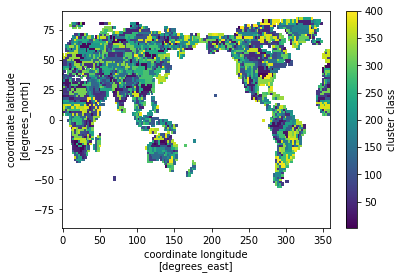

In [21]:
ds.cclass.plot()

### read in an example output file

In [23]:
f = '/glade/scratch/djk2120/PPEn11/hist/CTL2010/PPEn08_CTL2010_OAAT0000.clm2.h0.2005-02-01-00000.nc'
ds2 = xr.open_dataset(f)
lats = ds2.grid1d_lat.values
lons = ds2.grid1d_lon.values

### plot up centroids from the output and from the sparsegrid

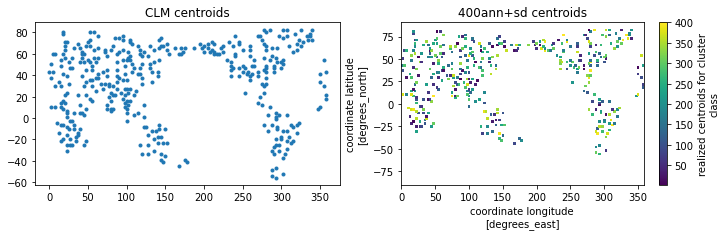

In [24]:
plt.figure(figsize=[12,3])
plt.subplot(121)
plt.plot(lons,lats,'.')
plt.title('CLM centroids')
plt.subplot(122)
ds.rcent.plot()
plt.title('400ann+sd centroids');

### the main thing
 - iterate through the CLM gridcells
 - retrieve the total represented landarea from Forrest

In [25]:
landarea = (ds.area*ds.landfrac).values
area  = np.zeros(400)
for i in range(400): 
    lat = lats[i]
    lon = lons[i]
    ixlat = abs(ds.lat-lat)<0.1
    ixlon = abs(ds.lon-lon)<0.1
    clust = ds.cclass[ixlat,ixlon].values
    ixc   = ds.cclass==clust
    area[i] = landarea[ixc].sum()
la = xr.DataArray(area,dims='gridcell',name='landarea')
la.attrs={'long_name':'total area of represented gridcells',
          'units':'km2'}

### write to netcdf

In [131]:
la.to_netcdf('sparsegrid_landarea.nc')

### check the value from the default params production run

In [116]:
thedir = '/glade/scratch/djk2120/ctsm51c6_PPEn08ctsm51d023_2deg_GSWP3V1_Sparse400_2000/run/'
thefile = glob.glob(thedir+'*.h0.*')[0]
base = xr.open_dataset(thefile)
nmonths = len(base.time)
yr0 = base['time.year'][0].values
base['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

In [145]:
gpp_mth_grid = 1e-9*24*60*60*month_wts(10)*la*base.GPP  #PgC/representd-gcell/mth
gpp_ann      = gpp_mth_grid.sum(dim='gridcell').groupby('time.year').sum()

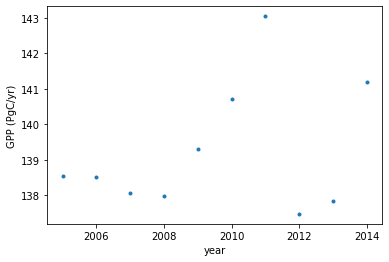

In [148]:
gpp_ann.plot.line('.')
plt.ylabel('GPP (PgC/yr)');

In [149]:
gpp_ann.mean()

<xarray.DataArray ()>
array(139.26398402)

### create a vector for pft output

In [29]:
f = '/glade/scratch/djk2120/PPEn11/hist/CTL2010/PPEn08_CTL2010_OAAT0000.clm2.h1.2005-02-01-00000.nc'
ds2 = xr.open_dataset(f)

In [30]:
lats = ds2.pfts1d_lat
lons = ds2.pfts1d_lon
wts  = ds2.pfts1d_wtgcell

In [31]:
landarea = (ds.area*ds.landfrac).values
nx = len(lats)
area_pft  = np.zeros(nx)
for i in range(nx): 
    lat = lats[i]
    lon = lons[i]
    ixlat = abs(ds.lat-lat)<0.1
    ixlon = abs(ds.lon-lon)<0.1
    clust = ds.cclass[ixlat,ixlon].values
    ixc   = ds.cclass==clust
    area_pft[i] = wts[i]*landarea[ixc].sum()

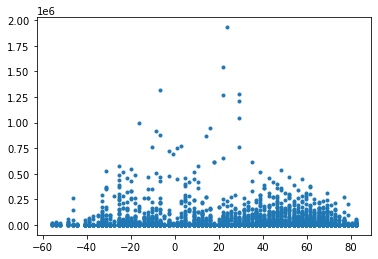

In [32]:
plt.plot(lats,area_pft,'.')

In [33]:
area_pft.sum()

135285566.9312744

In [36]:
la_pft = xr.DataArray(area_pft,dims='pft',name='landarea_pft')
la_pft.attrs={'long_name':'total area of represented patches','units':'km2'}

In [39]:
ds_out = xr.Dataset()
ds_out['landarea_pft'] = la_pft
ds_out['landarea'] = la

In [40]:
ds_out

<xarray.Dataset>
Dimensions:       (gridcell: 400, pft: 4387)
Dimensions without coordinates: gridcell, pft
Data variables:
    landarea_pft  (pft) float64 763.8 4.531e+03 7.405e+03 ... 0.0 0.0 0.0
    landarea      (gridcell) float64 4.388e+04 7.402e+04 ... 1.018e+05 4.207e+04